<a href="https://colab.research.google.com/github/tlk888/Yandex_ML-contest3_25s/blob/main/homeworks/hw01_classification/02_hw_fmnist_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [2]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________


def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        for param in params.split(", "):
            if "=" in param:
                key, value = param.split("=")
                param_dict[key.strip()] = eval(value.strip())
            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict


# __________end of block__________

In [4]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [5]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-09 14:33:10--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-09 14:33:11--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-KB/s 

In [6]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [7]:
CUDA_DEVICE_ID = 0  # change if needed

In [8]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 0')

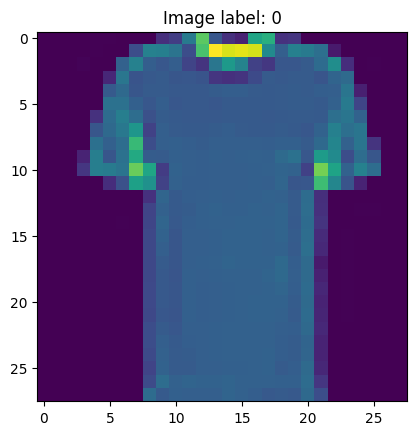

In [12]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [13]:
# Creating model instance
model_task_1 = None

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
        # Spatial attention
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)

    def forward(self, x):
        # Channel
        b, c, _, _ = x.size()
        avg = self.avg_pool(x).view(b, c)
        max = self.max_pool(x).view(b, c)
        channel_weights = self.fc(avg + max).view(b, c, 1, 1)
        x = x * channel_weights
        # Spatial
        avg = torch.mean(x, dim=1, keepdim=True)
        max, _ = torch.max(x, dim=1, keepdim=True)
        spatial = torch.cat([avg, max], dim=1)
        spatial_weights = torch.sigmoid(self.conv(spatial))
        return x * spatial_weights

class FashionMNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Block 1
        self.block1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        # Block 2
        self.block2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        # Block 3
        self.block3 = nn.Sequential(
            ResidualBlock(64, 128),
            CBAM(128)
        )
        # Block 4
        self.block4 = nn.Sequential(
            ResidualBlock(128, 256),
            CBAM(256)
        )
        # Classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x).squeeze()
        return self.fc(x)

# Создание экземпляра модели
model_task_1 = FashionMNISTModel()
#for m in model_task_1.modules():
#    if isinstance(m, nn.Conv2d):
#        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

Не забудьте перенести модель на выбранный `device`!

In [14]:
model_task_1.to(device)

FashionMNISTModel(
  (block1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64,

Локальные тесты для проверки вашей модели доступны ниже:

In [15]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [16]:
# Оптимизатор: AdamW с начальным LR=0.0005 и weight_decay=1e-4 для L2-регуляризации
optimizer = torch.optim.Adam(model_task_1.parameters(), lr=0.0005)

# Scheduler: ReduceLROnPlateau для динамического изменения LR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Функция потерь: CrossEntropyLoss для задачи классификации
criterion = nn.CrossEntropyLoss()

# Количество эпох
num_epochs = 30

# Переменные для ранней остановки
best_test_acc = 0.0
patience_counter = 0
patience_limit = 5  # Остановка после 5 эпох без улучшений

# Цикл обучения
for epoch in range(num_epochs):
    # Режим обучения
    model_task_1.train()
    train_loss = 0.0

    for images, labels in train_data_loader:
        images, labels = images.to(device), labels.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()

        # Прямой проход
        outputs = model_task_1(images)
        loss = criterion(outputs, labels)

        # Обратный проход и шаг оптимизации
        loss.backward()
        optimizer.step()

        # Суммируем Train Loss
        train_loss += loss.item() * images.size(0)

    # Средний Train Loss за эпоху
    train_loss /= len(train_data_loader.dataset)

    # Оценка на тестовом наборе
    model_task_1.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_task_1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Test Accuracy
    test_acc = 100 * correct / total

    # Обновляем scheduler на основе Test Accuracy
    scheduler.step(test_acc)

    # Текущий LR
    current_lr = optimizer.param_groups[0]['lr']

    # Вывод метрик
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}%, LR: {current_lr:.6f}")

    # Сохранение лучшей модели и ранняя остановка
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model_task_1.state_dict(), 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience_limit:
            print(f"Ранняя остановка на эпохе {epoch+1}. Лучшая Test Accuracy: {best_test_acc:.2f}%")
            break

if patience_counter < patience_limit:
    print(f"Обучение завершено. Лучшая Test Accuracy: {best_test_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


KeyboardInterrupt: 

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [78]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.99992


In [79]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.9303


Проверка, что необходимые пороги пройдены:

In [80]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Train accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

def class_wise_accuracy(model, test_loader, num_classes=10):
    model.eval()
    correct_pred = {class_idx: 0 for class_idx in range(num_classes)}
    total_pred = {class_idx: 0 for class_idx in range(num_classes)}

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            # Update counts for each class
            for label, prediction in zip(labels, predictions):
                class_idx = label.item()
                total_pred[class_idx] += 1
                if prediction == label:
                    correct_pred[class_idx] += 1

    # Calculate accuracy for each class
    class_acc = {}
    for class_idx in range(num_classes):
        if total_pred[class_idx] > 0:
            acc = 100 * correct_pred[class_idx] / total_pred[class_idx]
            class_acc[class_idx] = acc
        else:
            class_acc[class_idx] = 0.0  # Handle case with zero samples

    # Calculate overall accuracy
    total_correct = sum(correct_pred.values())
    total_samples = sum(total_pred.values())
    overall_acc = 100 * total_correct / total_samples

    return class_acc, overall_acc

class_acc, overall_acc = class_wise_accuracy(model_task_1, test_data_loader)

# Вывод результатов
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Overall Test Accuracy: {overall_acc:.2f}%")
print("\nClass-wise Accuracy:")
for idx, name in enumerate(class_names):
    print(f"{name:15}: {class_acc[idx]:.2f}%")

Overall Test Accuracy: 93.03%

Class-wise Accuracy:
T-shirt/top    : 89.40%
Trouser        : 98.60%
Pullover       : 90.80%
Dress          : 93.30%
Coat           : 90.60%
Sandal         : 98.60%
Shirt          : 75.80%
Sneaker        : 97.90%
Bag            : 98.10%
Ankle boot     : 97.20%


Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [84]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_fmnist_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!